# Overview 

Using PINN to solve the inverse problem (obtaining $c(\omega$)) for all station connections within a selected Box Region in Africa. Inversion results of all station connections are plotted both together and separately. 

## [0] In terminal, create a conda env for the project

conda create -n Bessel python=3 <br>
conda activate Bessel <br>
conda install jupyter numpy matplotlib <br>
conda install pytorch torchvision torchaudio -c pytorch <br>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.special as sp
import pandas as pd

# for computing the peak envelope
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline

In [2]:
# set the path to your local PINNdata folder
localData = '/Users/xuebaobao/Desktop/Bessel/OpenCode/PINNdata/'

## [1] Network Setups

In [3]:
class NeuralNet1(nn.Module):
    def __init__(self, input_dimension, output_dimension,
                 n_hidden_layers, neurons, retrain_seed,
                 PV_median, PV_range=0.8):
        super().__init__()
        torch.manual_seed(retrain_seed)
        self.PV_median, self.PV_range = PV_median, PV_range
        self.activation = nn.Tanh()
        self.input_layer = nn.Linear(input_dimension, neurons)
        self.hidden_layers = nn.ModuleList(
            nn.Linear(neurons, neurons)
            for _ in range(n_hidden_layers-1)
        )
        self.output_layer = nn.Linear(neurons, output_dimension)
        # Xavier init
        def init_weights(m):
            if isinstance(m, nn.Linear):
                gain = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(m.weight, gain=gain)
                nn.init.zeros_(m.bias)
        self.apply(init_weights)
    
    def forward(self, x):
        # first layer + activation
        x = self.activation(self.input_layer(x))
        
        # hidden layers
        for lin in self.hidden_layers:
            x = self.activation(lin(x))
            
        # output
        x = self.output_layer(x)
        x = torch.tanh(x) * self.PV_range + self.PV_median
        return x

## [2] Compute Bessel (and other functions)

In [4]:
class GetBessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, n, x):
        # detach tensors explicitly to convert to numpy
        n_numpy = n.detach().cpu().numpy()
        x_numpy = x.detach().cpu().numpy()

        # compute using scipy explicitly (no grad tracking needed here)
        result_numpy = sp.jv(n_numpy, x_numpy)

        # save tensors explicitly for backward pass
        ctx.save_for_backward(n, x)

        # convert numpy results explicitly back to tensor
        result_tensor = torch.tensor(result_numpy, dtype=x.dtype, device=x.device)

        return result_tensor

    @staticmethod
    def backward(ctx, grad_output):
        n, x = ctx.saved_tensors

        # explicitly detach and convert for scipy (no grad tracking here)
        n_numpy = n.detach().cpu().numpy()
        x_numpy = x.detach().cpu().numpy()

        # compute derivative explicitly with scipy (standard bessel derivative identity)
        grad_x_numpy = (sp.jv(n_numpy - 1, x_numpy) - sp.jv(n_numpy + 1, x_numpy)) / 2

        # convert explicitly back to torch tensor
        grad_x = torch.tensor(grad_x_numpy, dtype=x.dtype, device=x.device)

        # propagate explicitly through grad_output
        grad_x = grad_output * grad_x

        # no gradient for order (n) since typically it’s an integer constant
        grad_n = None  

        return grad_n, grad_x


In [5]:
# Limit the range of phase velocity by approximating the upper and lower bounds proposed by Ekstrom et al. (2009)
def get_cw_median(input_f, RayWave):
    # input_f is a 2D tensor with size (N,1)
    
    cw_median = torch.from_numpy(input_f * -2.6 + 3.7).float().reshape(-1,1)

    if not RayWave:
        # for Love waves, increase the median by 0.5 km/s:
        cw_median = cw_median + 0.5

    return cw_median

In [6]:
# compute the envelope using Hilbert trasform 

import math
from scipy.fftpack import *

def hilbert_from_scratch(u):
    # N : fft length
    # M : number of elements to zero out
    # U : DFT of u
    # v : IDFT of H(U)

    N = len(u)
    # take forward Fourier transform
    U = fft(u)
    M = N - N//2 - 1
    # zero out negative frequency components
    U[N//2+1:] = [0] * M
    # double fft energy except @ DC0
    U[1:N//2] = 2 * U[1:N//2]
    # take inverse Fourier transform
    v = ifft(U)
    
    return v

In [7]:
# same as the smooth function in Matlab (need WSZ be odd number)
def smooth(a, WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, must be an odd number
    
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    
    return np.concatenate((start, out0, stop))

## [3] Define Loss Functions

The loss function has several components: <br>
(1): the difference between NCF (observations) and NN2 output out_NCF <br>
(2): constrains the smoothness in c(f) (to avoid sudden changes in c(f))

In [8]:
# compute the total loss of the network
def compute_loss(out_PV, input_f, input_NCF, Lambdas, dist_r, RayWave):

    # define the weight of each loss term
    [lambda1, lambda2] = Lambdas

    # compute J0(x) using PV
    out_x = input_f * dist_r * 2 * np.pi / out_PV
    if RayWave:
        out_Bessel = GetBessel.apply(torch.tensor(0), out_x)
    else:
        out_Bessel = (GetBessel.apply(torch.tensor(0), out_x) - GetBessel.apply(torch.tensor(2), out_x))/2

    ### Loss1: observation (NCF) vs. J_0(x)
    loss1 = torch.mean((input_NCF - out_Bessel)**2)
    
    ### Loss2: constrain the smoothness of c(w)
    grad_out_PV = torch.autograd.grad(out_PV, input_f, grad_outputs=torch.ones_like(out_PV), create_graph=True)[0]
    grad_out_PV2 = torch.autograd.grad(grad_out_PV, input_f, grad_outputs=torch.ones_like(out_PV), create_graph=True)[0]
    loss2 = torch.mean(grad_out_PV2 ** 2)

    # add up to get the total loss
    loss = lambda1 * loss1 + lambda2 * loss2 
    
    # print(
    #     "Total loss: ", round(loss.item(), 4),
    #     "| Fitting Loss: ", round(loss1.item(), 4),
    #     "| Smooth Loss: ", round(loss2.item(), 4))
    
    return loss
    

## [4] Train the PINN

In [9]:
I_set_seed = 123

def train_PINN(input_f, noisyNCF, RayWave, Lambdas, dist_r, c_median, nnlayer, lr=float(1), nnneuoron=40):
   
    # Create PINN 
    approximate_PV = NeuralNet1(input_dimension=1, output_dimension=1, n_hidden_layers=nnlayer, neurons=nnneuoron, 
                            retrain_seed=I_set_seed, PV_median=c_median)
    
    # Define training parameters
    n_epochs = 1
    max_iter = 10000
    
    # to store the loss
    history = list()
    
    # define the optimizer
    optimizer_LBFGS = torch.optim.LBFGS(list(approximate_PV.parameters()),
                                  lr=lr,
                                  max_iter=max_iter,
                                  max_eval=50000,
                                  history_size=300,
                                  line_search_fn="strong_wolfe",
                                  tolerance_grad=1e-10,
                                  tolerance_change=1e-10)
    
    # Define a closure for the optimizer
    def closure():
        optimizer_LBFGS.zero_grad()
    
        # forward steps
        out_PV = approximate_PV(input_f)  # NN1 outputs phase velocity
        
        # compute the loss
        loss = compute_loss(out_PV, input_f, noisyNCF, Lambdas, dist_r, RayWave)

        history.append(loss.item())
        
        # backpropagate joint loss
        loss.backward()
    
        return loss
    
    for epoch in range(n_epochs):
        # print("################################ ", epoch, " ################################")
    
        # take optimizer step
        current_loss = optimizer_LBFGS.step(closure)

    # get the final inversion results
    infer_PV = approximate_PV(input_f)
    infer_x = input_f * dist_r * 2 * np.pi / infer_PV

    if RayWave:
        infer_Bessel = GetBessel.apply(torch.tensor(0), infer_x)
    else:
        infer_Bessel = (GetBessel.apply(torch.tensor(0), infer_x) - GetBessel.apply(torch.tensor(2), infer_x))/2

    return infer_PV, infer_Bessel, history, approximate_PV

## [5] PINN Doing Inversion

In [10]:
def PINN_invert(stapair, stadist):
    # Read in the NCF
    dataLove = np.loadtxt(localData + 'BoxRegion/LoveResponse/dispersion_' + stapair + '.txt', 
                          delimiter=' ', skiprows=2)
    NCF_f = dataLove[:,0]
    Love_NCF = smooth(dataLove[:,1], 11)
    
    dataRay = np.loadtxt(localData + 'BoxRegion/RayResponse/dispersion_' + stapair + '.txt', 
                          delimiter=' ', skiprows=2)
    Ray_NCF = smooth(dataRay[:,1], 11)
    
    # read in AkiEstimate Results
    pred_f = []
    pred_LPV = []
    pred_LJ0 = []
    with open(localData + 'BoxRegion/BoxAkiEst/Final_' + stapair + '/opt.pred-love', 'r') as f:
        for line in f:
            # Split on whitespace
            tokens = line.split()
            
            # Convert each token to float
            floats = [float(tok) for tok in tokens]
            pred_f.append(floats[0])
            pred_LPV.append(floats[2]/1000)
            pred_LJ0.append(floats[5])
    
    pred_RPV = []
    pred_RJ0 = []
    with open(localData + 'BoxRegion/BoxAkiEst/Final_' + stapair + '/opt.pred-rayleigh', 'r') as f:
        for line in f:
            # Split on whitespace
            tokens = line.split()
            
            # Convert each token to float
            floats = [float(tok) for tok in tokens]
            pred_RPV.append(floats[2]/1000)
            pred_RJ0.append(floats[5])

    # Read in all the Bessel envelopes
    Bessel_envR = np.loadtxt(localData + 'BesselEnveRay.csv', delimiter=',', skiprows=1)
    Bessel_envL = np.loadtxt(localData + 'BesselEnveLove.csv', delimiter=',', skiprows=1)

    # find the best envelope to use 
    rdists = np.append(np.linspace(60, 250, 20), [np.linspace(300, 1000, 15)])
    iEnve = np.argmin(np.abs(rdists - stadist))
    iBenvR = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_envR[:, iEnve])
    iBenvL = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_envL[:, iEnve])

    # Normalize the NCF by its Hilbert envelope
    Love_HilbEnve = np.abs(hilbert_from_scratch(Love_NCF))
    Ray_HilbEnve = np.abs(hilbert_from_scratch(Ray_NCF))
    
    Love_NCFHilb = Love_NCF * (iBenvL / Love_HilbEnve)
    Ray_NCFHilb = Ray_NCF * (iBenvR / Ray_HilbEnve)

    # TRAIN the neural network
    nnlayer = 4
    nnneuoron = 40
    
    freqmax = 3100
    freqmin = 359
    
    #### [Rayleigh Wave] ####
    RayWave = 1
    
    # set the hyperparameters for the loss function
    Lambdas = [1e0, 1e-8] # weight for different loss terms
    
    # get the median to set the range of possible phase velocity
    c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]
    
    input_NCF = torch.from_numpy(Ray_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
    input_NCF.requires_grad = True
    
    # set the input_f so that can compute the gradient of PV in the loss function
    input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
    input_f.requires_grad = True
    input_f.allow_unused = True
    
    # train the PINN
    infer_PV_Ray, infer_Bessel_Ray, history_Ray, Model_Ray = train_PINN(input_f, input_NCF, RayWave, 
                                                          Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)
    
    #### [Love Wave] ####
    RayWave = 0
    
    # set the hyperparameters for the loss function
    Lambdas = [1e0, 1e-8] # weight for different loss terms
    
    # get the median to set the range of possible phase velocity
    c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]
    
    input_NCF = torch.from_numpy(Love_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
    input_NCF.requires_grad = True
    
    # set the input_f so that can compute the gradient of PV in the loss function
    input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
    input_f.requires_grad = True
    input_f.allow_unused = True
    
    # train the PINN
    infer_PV_Love, infer_Bessel_Love, history_Love, Model_Love = train_PINN(input_f, input_NCF, RayWave, 
                                                          Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)

    plot_f = input_f.detach().numpy()[:,0]
   
    # return the phase velocity results to mstrices
    return pred_f, pred_RPV, pred_LPV, plot_f, infer_PV_Ray.detach().numpy()[:,0], infer_PV_Love.detach().numpy()[:,0]

In [11]:
# Run through all station pairs in the list
df = pd.read_csv(localData + 'BoxRegion/Boxconn.csv')

# # fig, axes = plt.subplots(2,2)
inferRs = np.zeros((68, 2741))
inferLs = np.zeros((68, 2741))

for index, row in df.iterrows():
    
    stapair = row['net1']+'-'+row['sta1']+'_'+row['net2']+'-'+row['sta2']
    stadist = row['distance_km']
    
    pred_f, pred_RPV, pred_LPV, plot_f, infer_PV_Ray, infer_PV_Love = PINN_invert(stapair, stadist)

    inferRs[index, :] = infer_PV_Ray
    inferLs[index, :] = infer_PV_Love


## [6] Plot all Station Connections

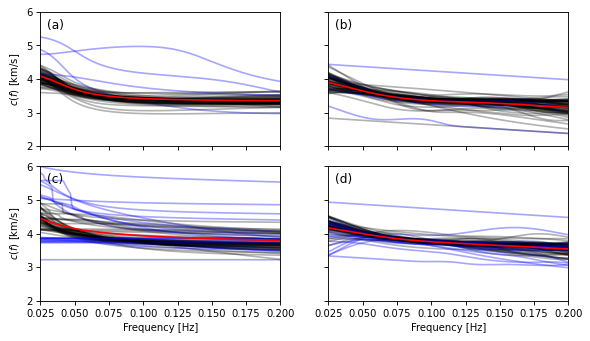

In [12]:
matplotlib.rcParams.update({'font.size': 9})
fig, axes = plt.subplots(2,2, figsize=(7.5, 4.3), dpi=80, sharex=True, sharey=True,
                        gridspec_kw = dict( left = 0.08, right = 0.96, bottom = 0.11, top = 0.95, hspace = 0.15))

avg_predR = np.zeros(len(pred_f[359:2880]))
avg_predL = np.zeros(len(pred_f[359:2880]))

for index, row in df.iterrows():
    
    stapair = row['net1']+'-'+row['sta1']+'_'+row['net2']+'-'+row['sta2']

    # read in AkiEstimate Results
    pred_f = []
    pred_LPV = []
    pred_LJ0 = []
    with open(localData + 'BoxRegion/BoxAkiEst/Final_' + stapair + '/opt.pred-love', 'r') as f:
        for line in f:
            # Split on whitespace
            tokens = line.split()
            
            # Convert each token to float
            floats = [float(tok) for tok in tokens]
            pred_f.append(floats[0])
            pred_LPV.append(floats[2]/1000)
            pred_LJ0.append(floats[5])
    
    pred_RPV = []
    pred_RJ0 = []
    with open(localData + 'BoxRegion/BoxAkiEst/Final_' + stapair + '/opt.pred-rayleigh', 'r') as f:
        for line in f:
            # Split on whitespace
            tokens = line.split()
            
            # Convert each token to float
            floats = [float(tok) for tok in tokens]
            pred_RPV.append(floats[2]/1000)
            pred_RJ0.append(floats[5])

    # Plot Rayleigh Results
    if (pred_RPV[1100] > 3.8) | (pred_RPV[359] > 4.5):
        pltcolor = 'b'
        pltalpha = 0.35
    else:
        pltcolor = 'k'
        pltalpha = 0.3
    
    axes[0,0].plot(pred_f[359:2880], pred_RPV[359:2880], color=pltcolor, alpha=pltalpha)
    axes[0,1].plot(plot_f, inferRs[index, :], color=pltcolor, alpha=pltalpha)

    # Plot Love Results
    if (pred_LPV[359] > 5) | (pred_LPV[359] < 4):
        pltcolor = 'b'
        pltalpha = 0.35
    else:
        pltcolor = 'k'
        pltalpha = 0.3

    axes[1,0].plot(pred_f[359:2880], pred_LPV[359:2880], color=pltcolor, alpha=pltalpha)
    axes[1,1].plot(plot_f, inferLs[index, :], color=pltcolor, alpha=pltalpha)

    avg_predR = avg_predR + pred_RPV[359:2880]
    avg_predL = avg_predL + pred_LPV[359:2880]


axes[0,0].plot(pred_f[359:2880], avg_predR/68, 'r')
axes[1,0].plot(pred_f[359:2880], avg_predL/68, 'r')
axes[0,1].plot(plot_f, np.mean(inferRs, 0), 'r')
axes[1,1].plot(plot_f, np.mean(inferLs, 0), 'r')

axes[1,0].set_xlabel('Frequency [Hz]')
axes[1,1].set_xlabel('Frequency [Hz]')
axes[0,0].set_ylabel(r'$c(f)$ [km/s]')
axes[1,0].set_ylabel(r'$c(f)$ [km/s]')

axes[0,0].text(0.03, 5.5, '(a)', fontsize=11, color='k')
axes[0,1].text(0.03, 5.5, '(b)', fontsize=11, color='k')
axes[1,0].text(0.03, 5.5, '(c)', fontsize=11, color='k')
axes[1,1].text(0.03, 5.5, '(d)', fontsize=11, color='k')

axes[0,0].set_xlim([0.025, 0.2])
axes[0,0].set_ylim([2, 6]);

# plt.savefig( './Figures/Fig4_SmallRegion.pdf', dpi = 400, facecolor = 'w' )

## [7] Plot each individual station connection

/var/folders/lq/fvp6gy_j2h71xtc3ch5jv_gw0000gn/T/ipykernel_99640/3513454181.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2,2, figsize=(7.5, 4.3), dpi=80, sharex=True,


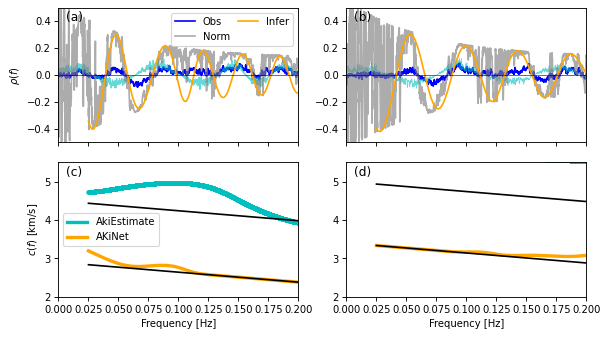

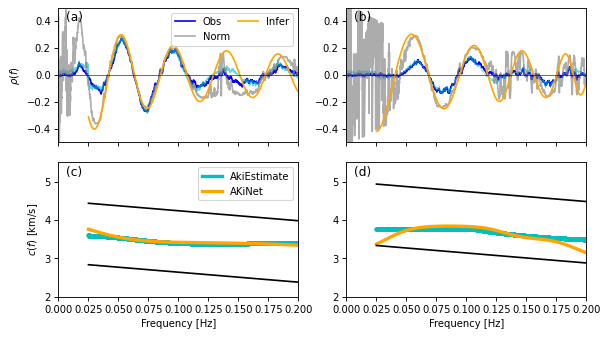

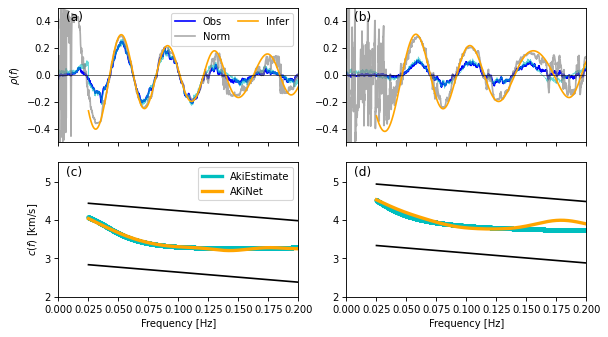

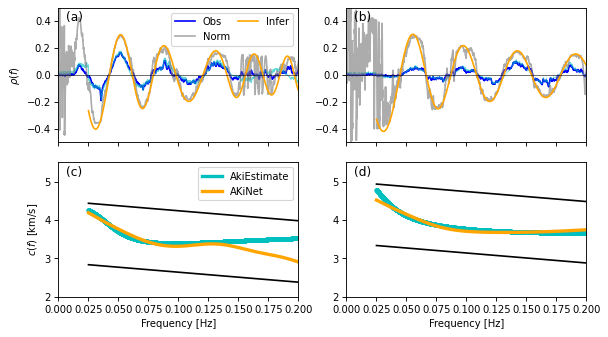

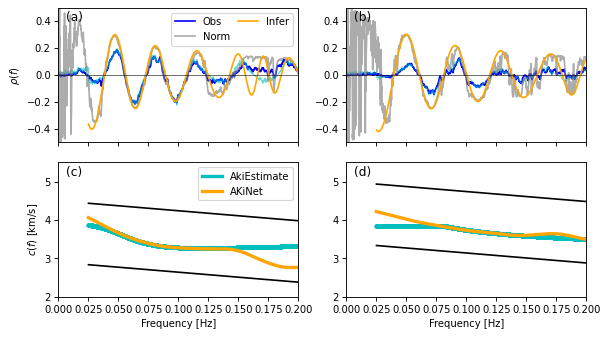

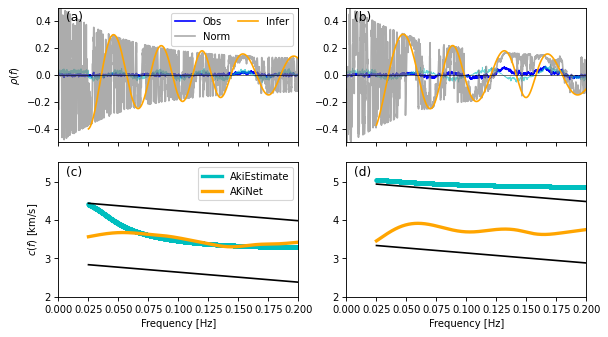

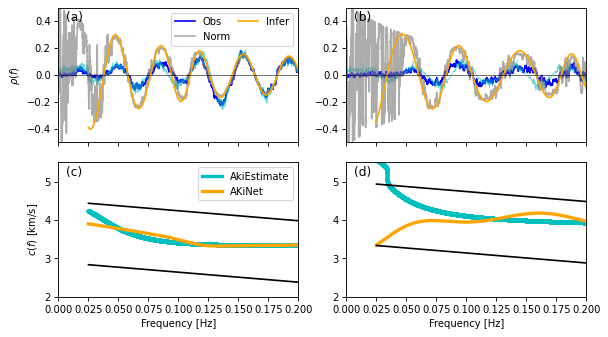

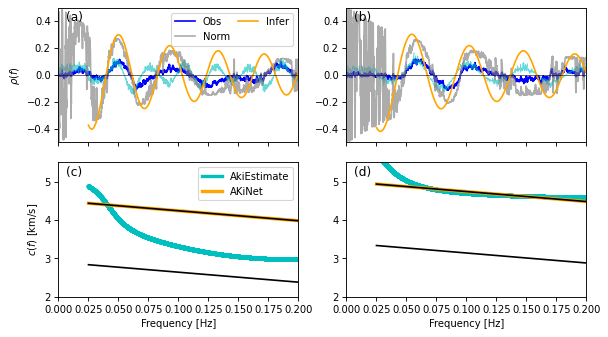

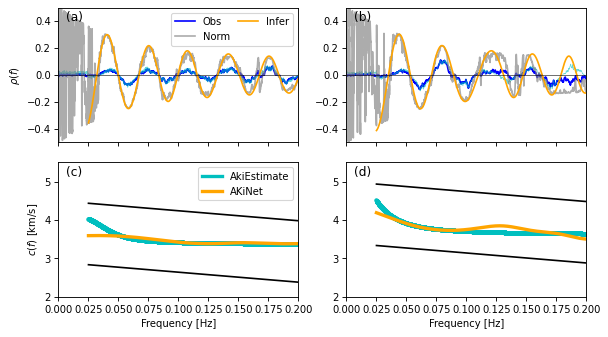

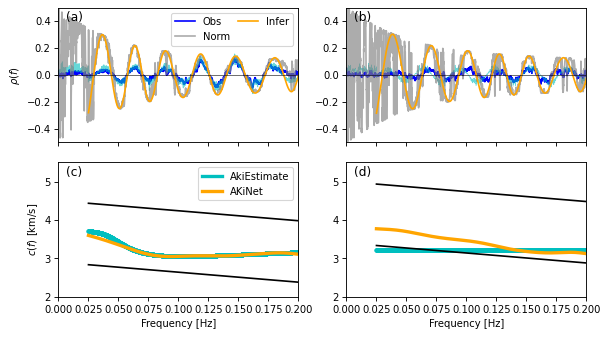

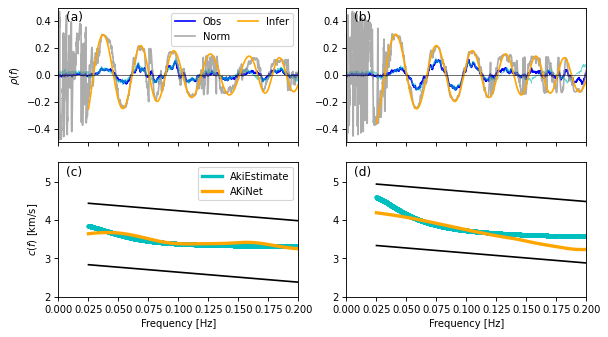

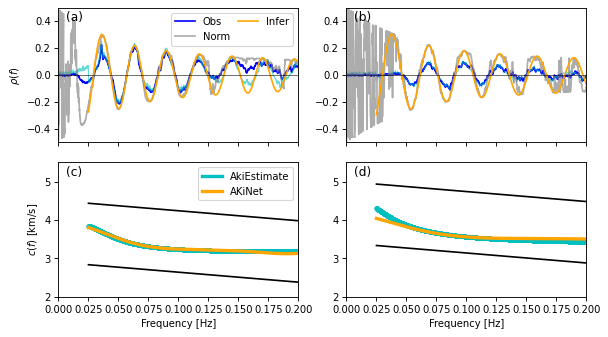

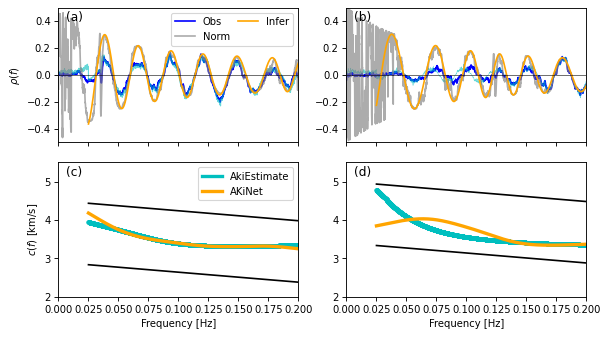

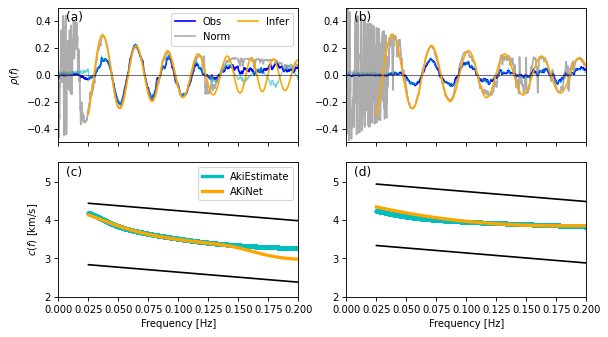

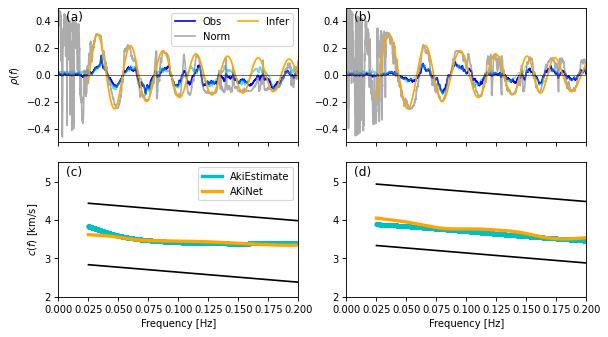

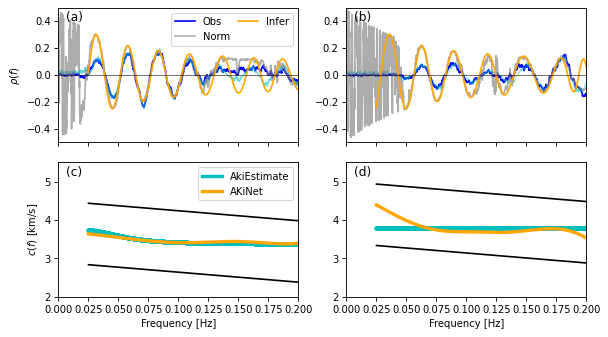

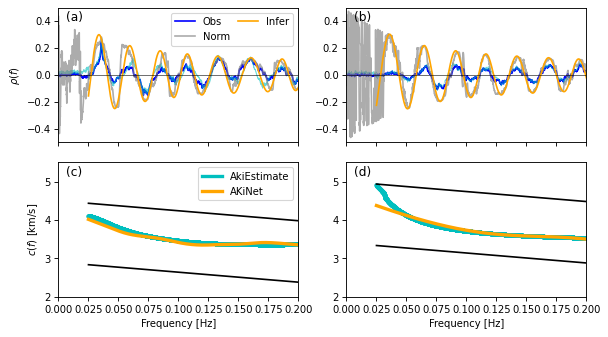

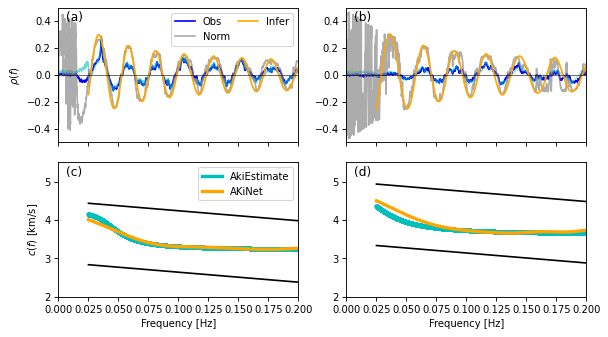

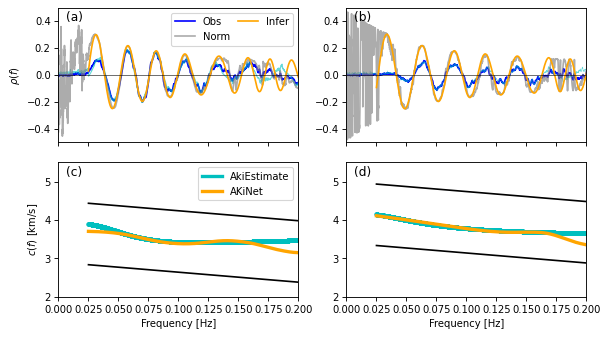

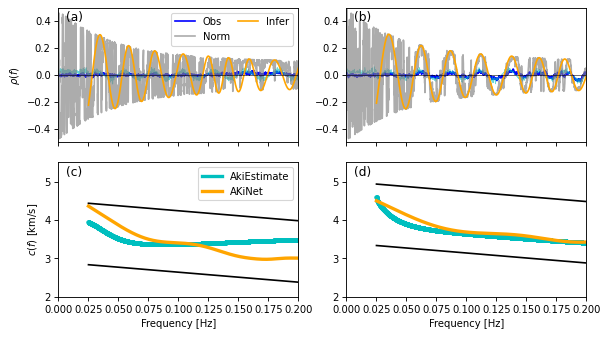

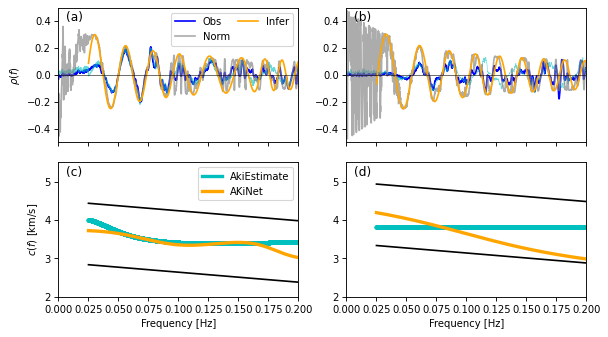

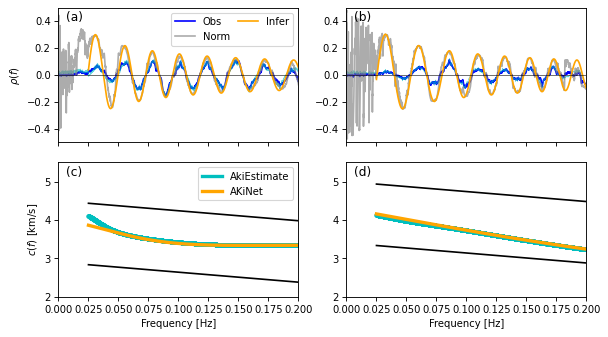

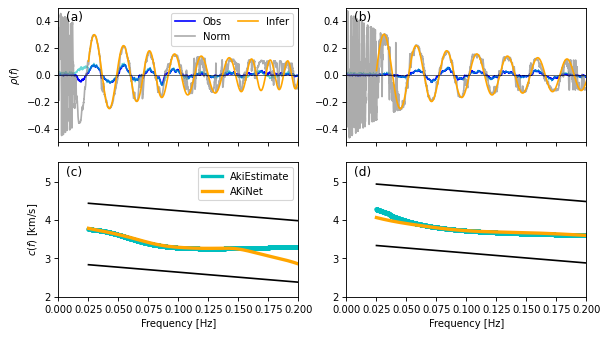

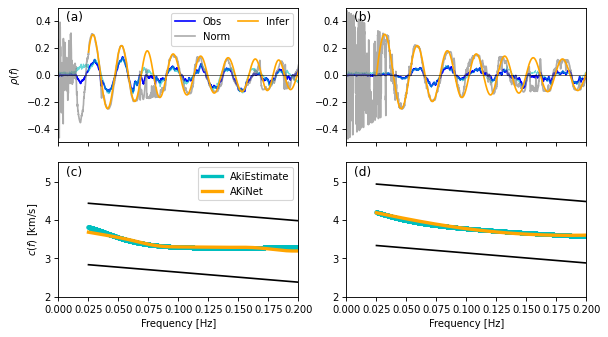

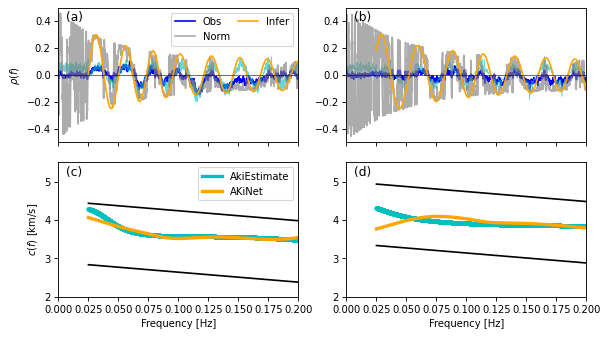

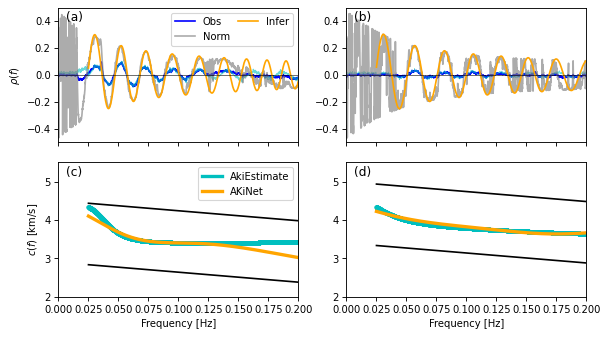

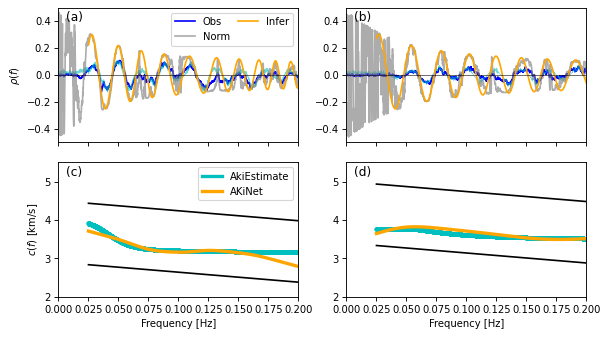

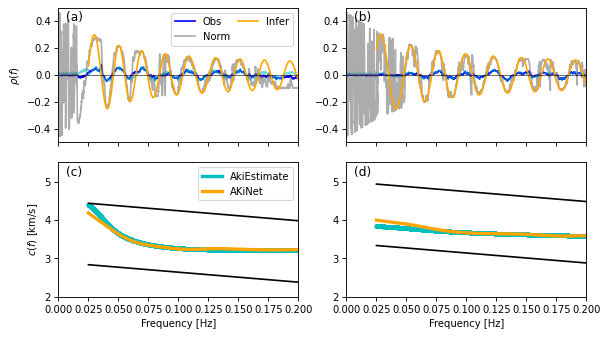

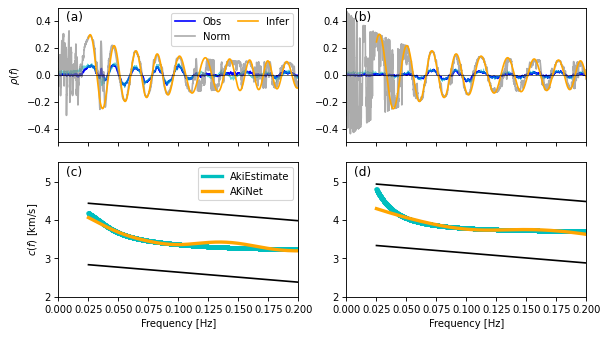

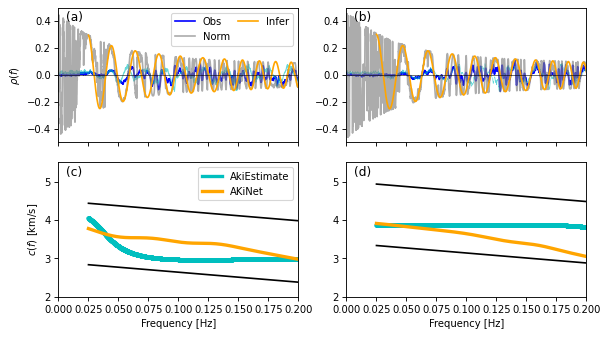

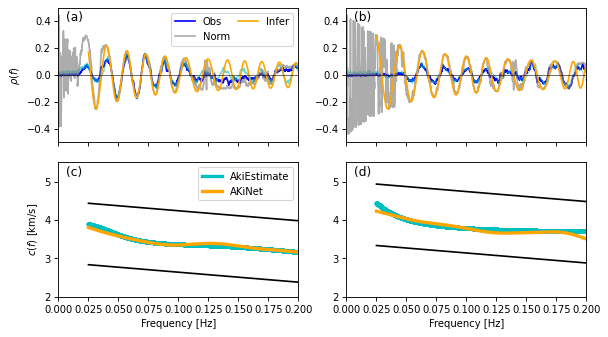

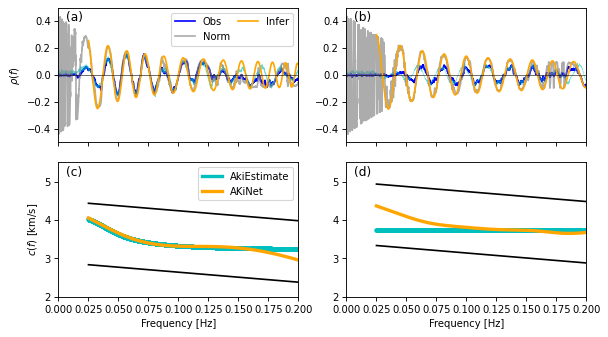

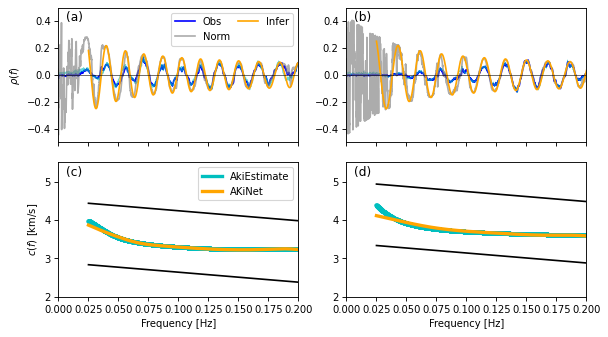

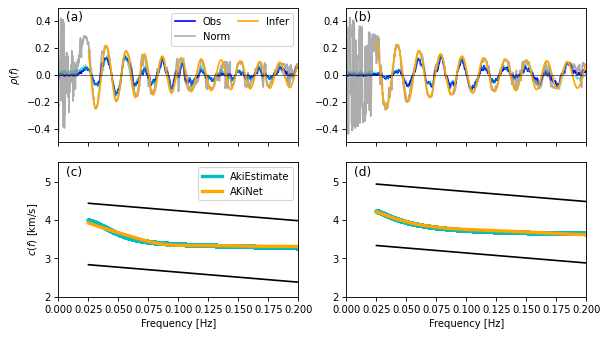

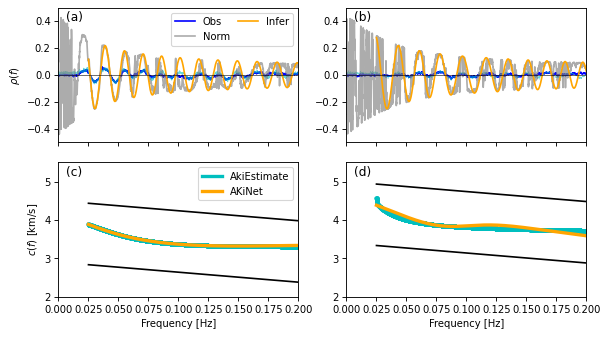

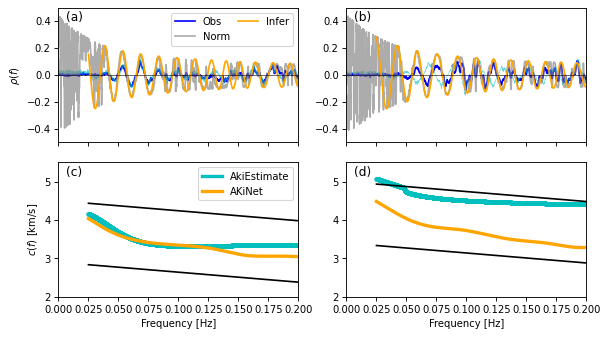

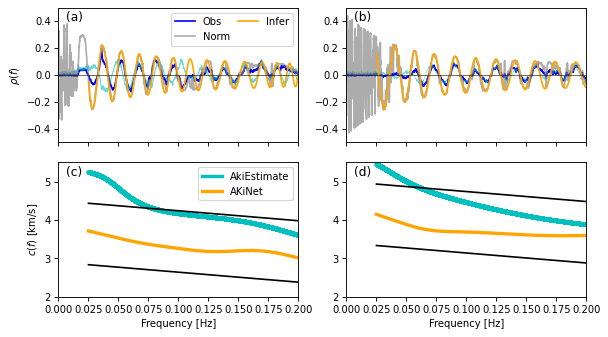

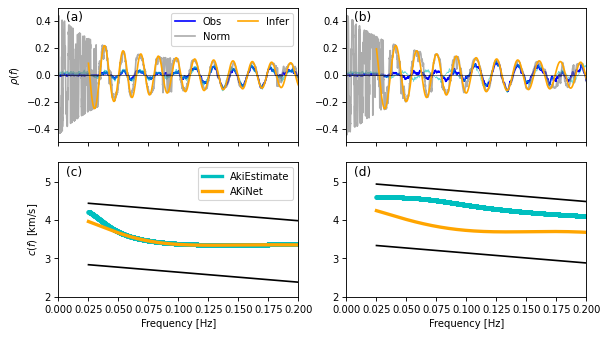

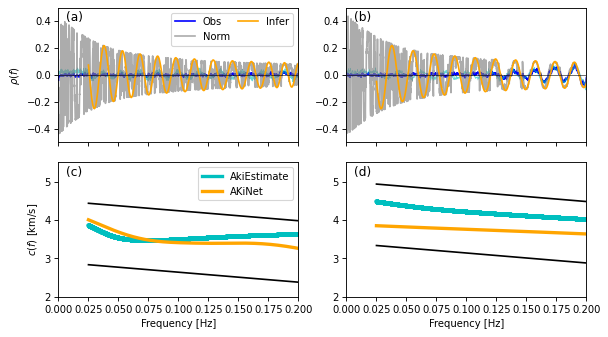

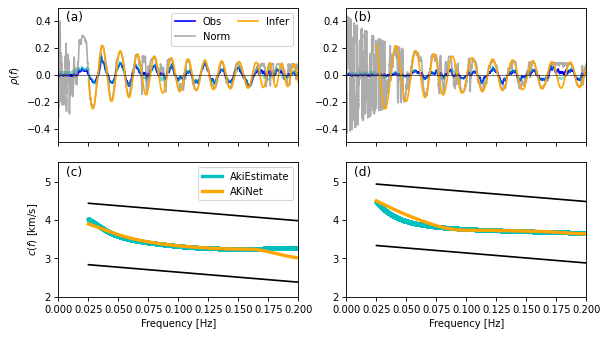

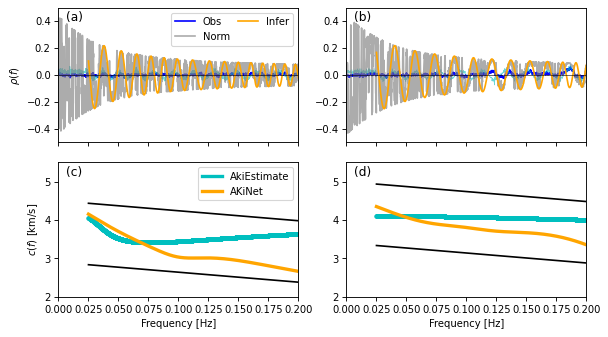

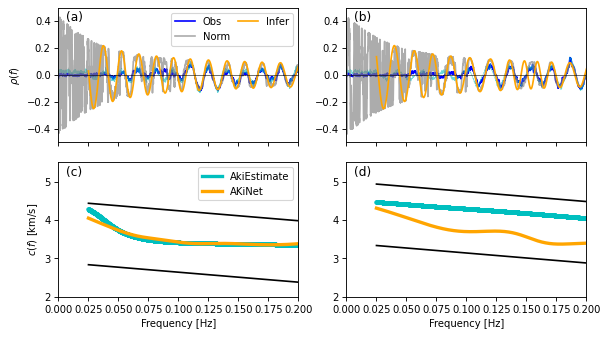

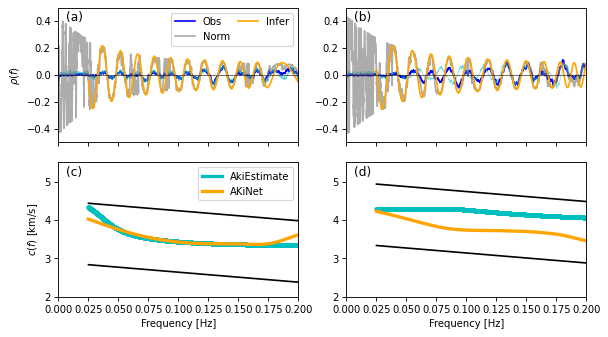

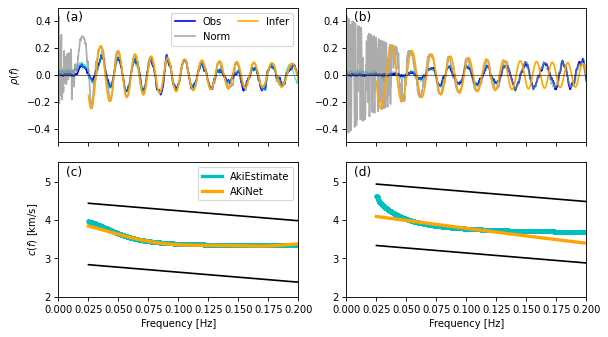

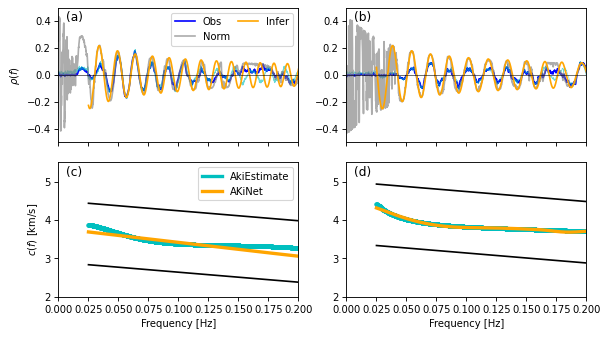

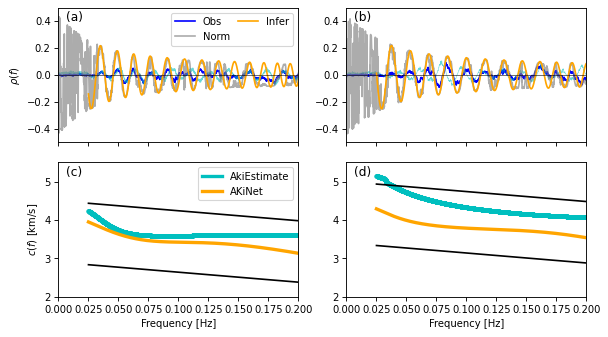

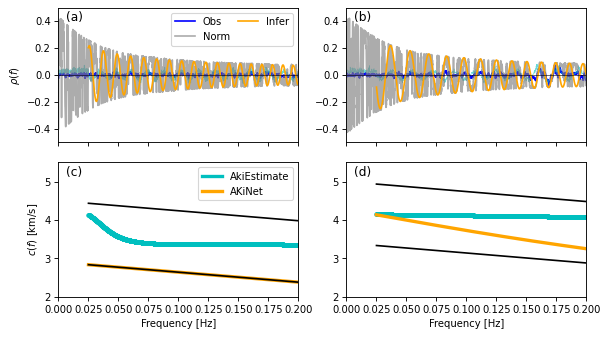

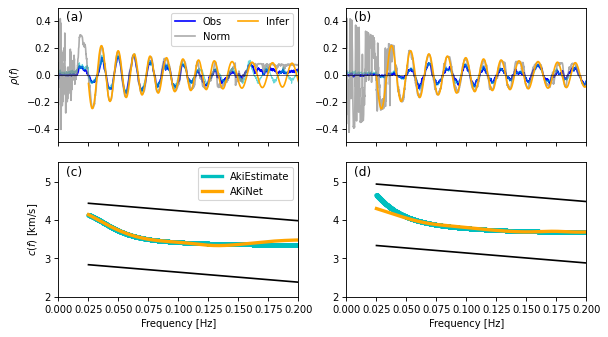

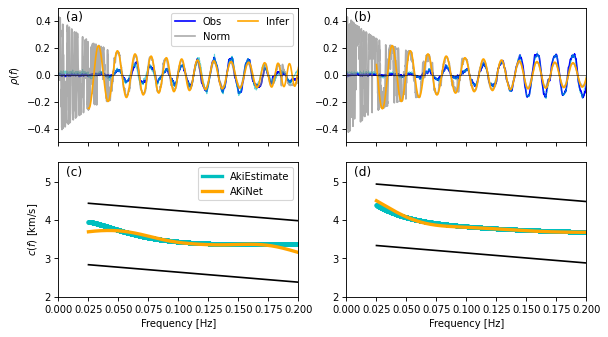

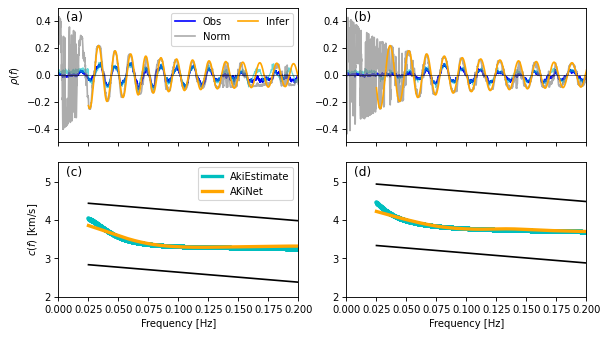

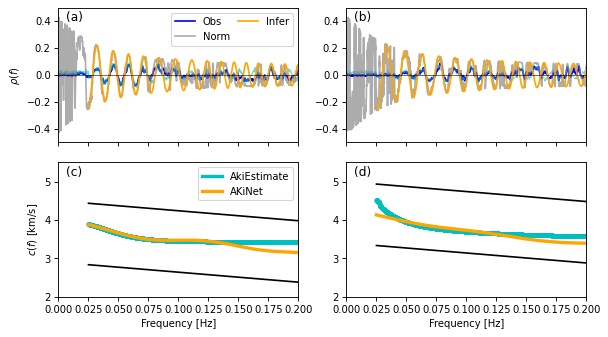

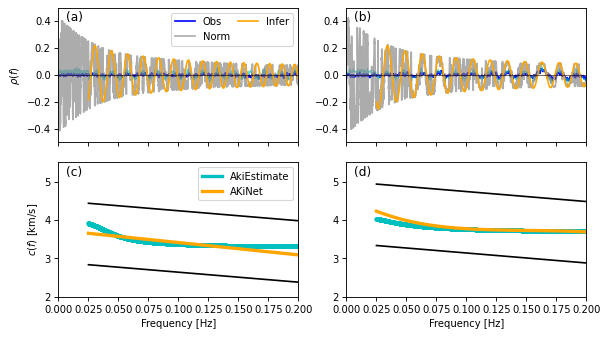

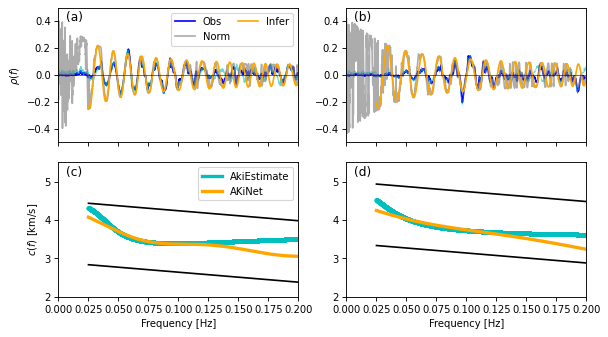

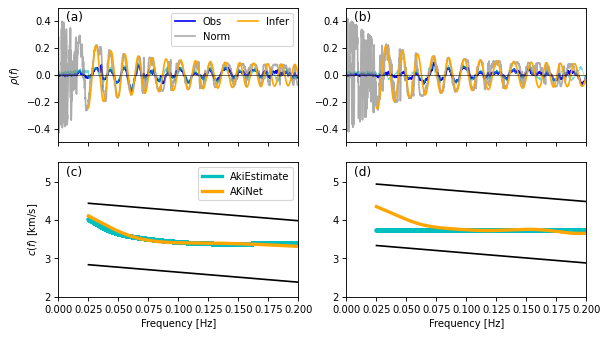

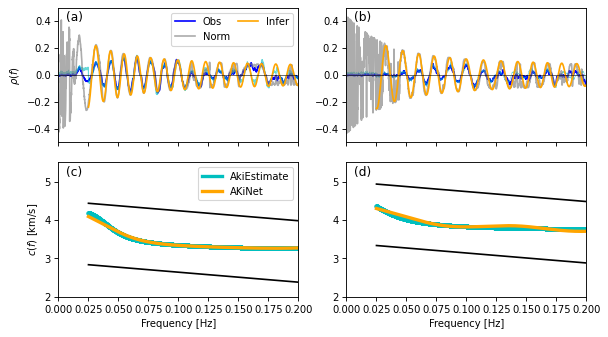

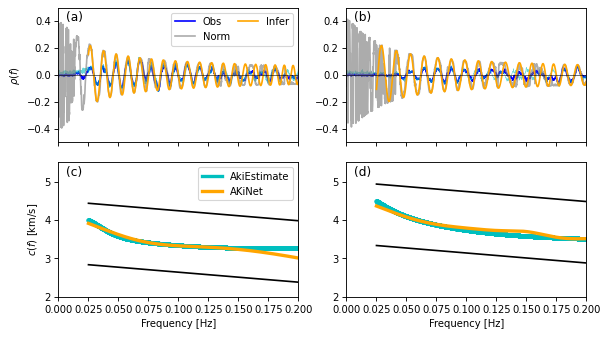

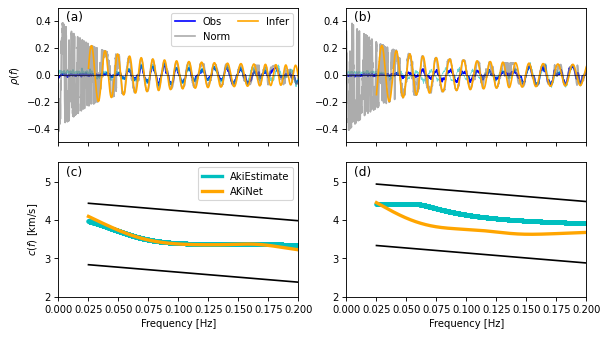

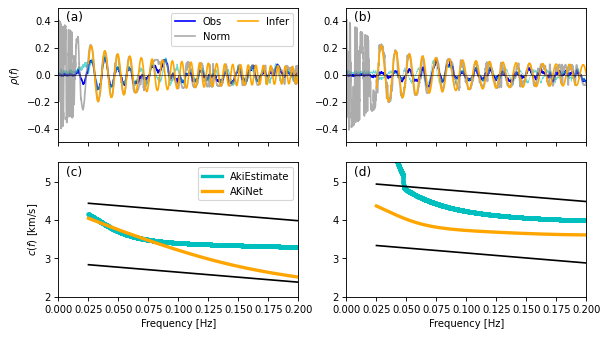

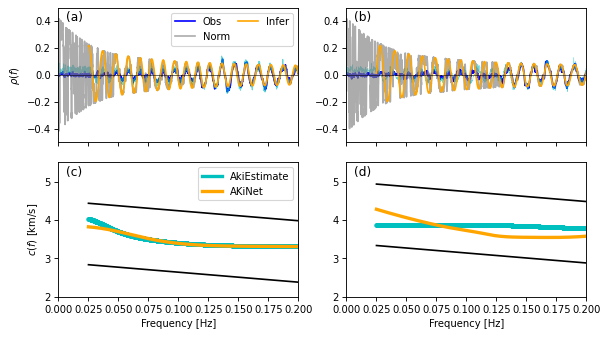

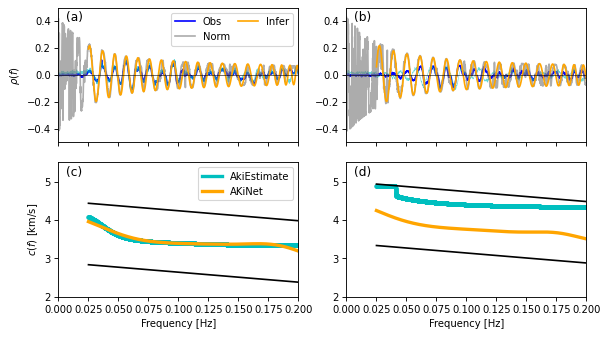

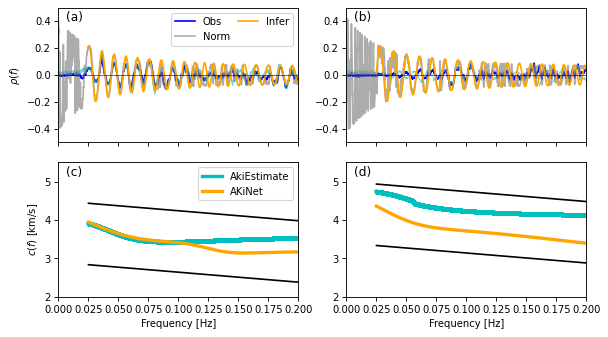

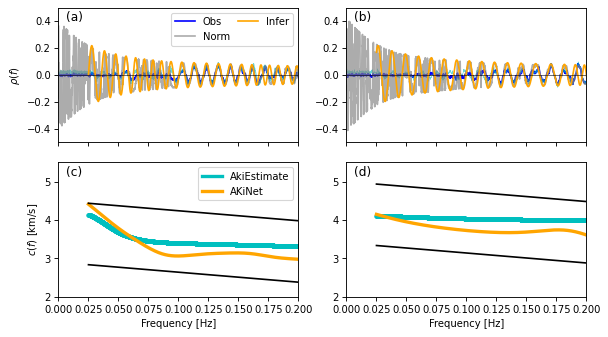

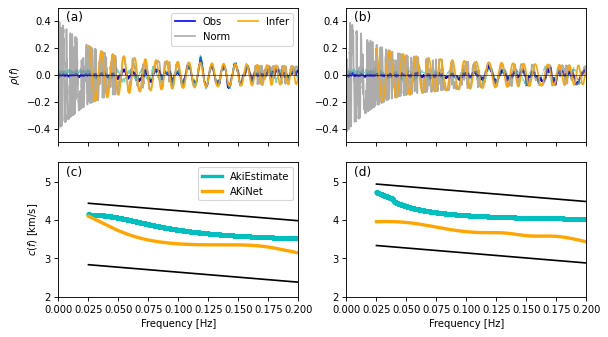

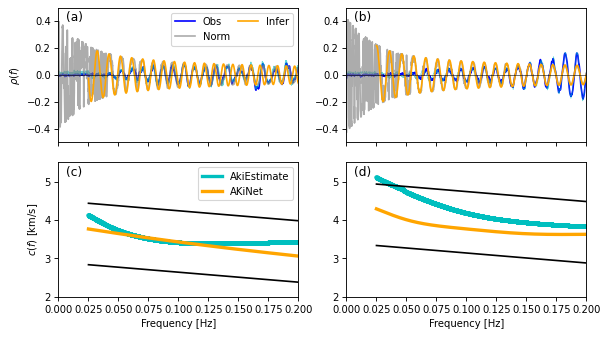

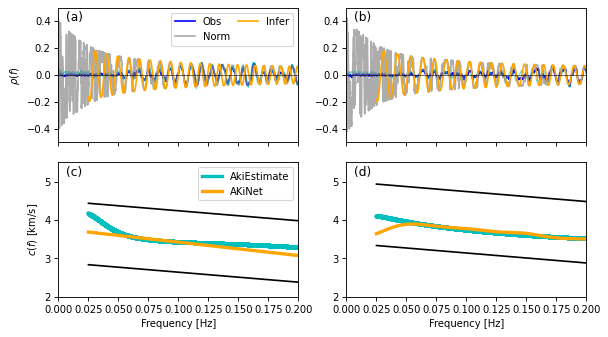

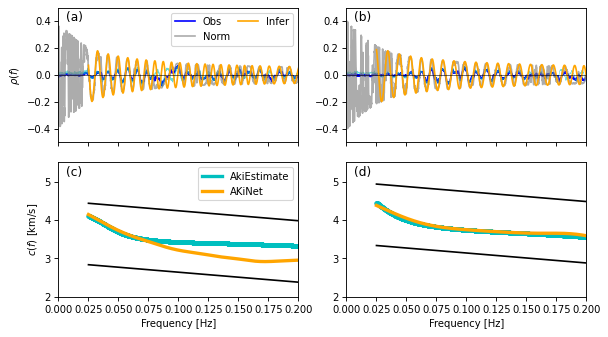

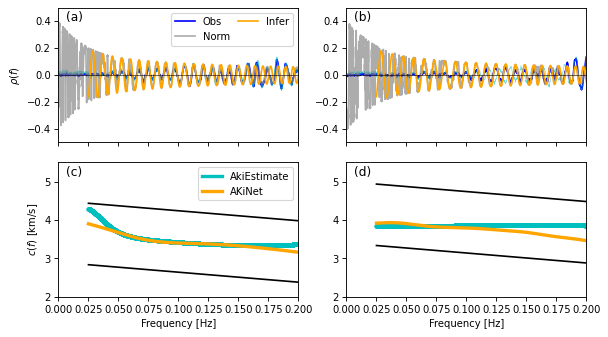

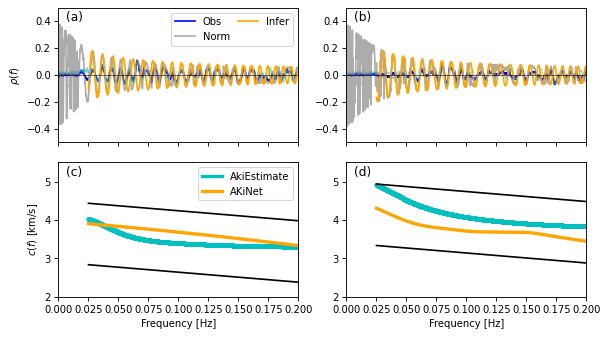

In [13]:
# To individually plot (and save) AkiNet & AkiEstimate & NCF for each station pair

# Read in all the Bessel envelopes
Bessel_envR = np.loadtxt(localData + 'BesselEnveRay.csv', delimiter=',', skiprows=1)
Bessel_envL = np.loadtxt(localData + 'BesselEnveLove.csv', delimiter=',', skiprows=1)

for index, row in df.iterrows():
    # Plot & Save one single station pair
    stapair = row['net1']+'-'+row['sta1']+'_'+row['net2']+'-'+row['sta2']
    stadist = row['distance_km']

    # read in AkiEstimate Results
    dataLove = np.loadtxt(localData + 'BoxRegion/LoveResponse/dispersion_' + stapair + '.txt', 
                          delimiter=' ', skiprows=2)
    NCF_f = dataLove[:,0]
    Love_NCF = smooth(dataLove[:,1], 11)
    
    dataRay = np.loadtxt(localData + 'BoxRegion/RayResponse/dispersion_' + stapair + '.txt', 
                          delimiter=' ', skiprows=2)
    Ray_NCF = smooth(dataRay[:,1], 11)

    pred_f = []
    pred_LPV = []
    pred_LJ0 = []
    with open(localData + 'BoxRegion/BoxAkiEst/Final_' + stapair + '/opt.pred-love', 'r') as f:
        for line in f:
            # Split on whitespace
            tokens = line.split()
            
            # Convert each token to float
            floats = [float(tok) for tok in tokens]
            pred_f.append(floats[0])
            pred_LPV.append(floats[2]/1000)
            pred_LJ0.append(floats[5])
    
    pred_RPV = []
    pred_RJ0 = []
    with open(localData + 'BoxRegion/BoxAkiEst/Final_' + stapair + '/opt.pred-rayleigh', 'r') as f:
        for line in f:
            # Split on whitespace
            tokens = line.split()
            
            # Convert each token to float
            floats = [float(tok) for tok in tokens]
            pred_RPV.append(floats[2]/1000)
            pred_RJ0.append(floats[5])

    
    # compute the AkiNet Bessel 
    out_x = plot_f * stadist * 2 * np.pi / inferRs[index, :]
    infer_Bessel_Ray = GetBessel.apply(torch.tensor(0), torch.from_numpy(out_x).float().reshape(-1,1))
    out_x = plot_f * stadist * 2 * np.pi / inferLs[index, :]
    infer_Bessel_Love = (GetBessel.apply(torch.tensor(0), torch.from_numpy(out_x).float().reshape(-1,1)) 
                  - GetBessel.apply(torch.tensor(2), torch.from_numpy(out_x).float().reshape(-1,1)))/2

    # Compute the normalized NCF
    # find the closest envelope to use 
    rdists = np.append(np.linspace(60, 250, 20), [np.linspace(300, 1000, 15)])
    iEnve = np.argmin(np.abs(rdists - stadist))
    iBenvR = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_envR[:, iEnve])
    iBenvL = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_envL[:, iEnve])

    # Normalize the NCF by its Hilbert envelope
    Love_HilbEnve = np.abs(hilbert_from_scratch(Love_NCF))
    Ray_HilbEnve = np.abs(hilbert_from_scratch(Ray_NCF))
    
    Love_NCFHilb = Love_NCF * (iBenvL / Love_HilbEnve)
    Ray_NCFHilb = Ray_NCF * (iBenvR / Ray_HilbEnve)
    
    # Plot the station connection
    matplotlib.rcParams.update({'font.size': 9})
    fig, axes = plt.subplots(2,2, figsize=(7.5, 4.3), dpi=80, sharex=True, 
                            gridspec_kw = dict( left = 0.09, right = 0.97, bottom = 0.11, top = 0.95, hspace = 0.15))
    
    # matplotlib.rcParams.update({'font.size': 14})
    # fig, axes = plt.subplots(2,2, figsize=(14, 6), dpi=80, sharex=True, 
    #                         gridspec_kw = dict( left = 0.18, right = 0.94, bottom = 0.1, top = 0.98, hspace = 0.15))
    
    axes[0,0].plot(NCF_f, Ray_NCF, 'b', label='Obs')
    axes[0,0].plot(pred_f, pred_RJ0, 'c', alpha = 0.6, linewidth=1)
    axes[0,0].plot(NCF_f,  Ray_NCFHilb, 'gray', alpha = 0.65, label='Norm')
    axes[0,0].plot(plot_f, infer_Bessel_Ray.detach().numpy()[:,0], 'orange', label='Infer')
    axes[0,0].axhline(y = 0, linewidth = 0.5, color='k')
    axes[0,0].set_ylabel(r'$\rho(f)$')
    axes[0,0].legend(ncol=2, loc='upper right', columnspacing=0.85)
    axes[0,0].set_xlim([0, 0.2])
    axes[0,0].set_ylim([-0.5, 0.5])
    axes[0,0].text(0.006, 0.4, '(a)', fontsize=11, color='k')

    axes[0,1].plot(NCF_f, Love_NCF, 'b', label='NCF')
    axes[0,1].plot(pred_f, pred_LJ0, 'c', alpha = 0.6, linewidth=0.5)
    axes[0,1].plot(NCF_f,  Love_NCFHilb, 'gray', alpha = 0.65, label='NCF norm')
    axes[0,1].plot(plot_f, infer_Bessel_Love.detach().numpy()[:,0], 'orange', label='$J_0$ infer')
    axes[0,1].axhline(y = 0, linewidth = 0.5, color='k')
    axes[0,1].set_ylim([-0.5, 0.5])
    axes[0,1].text(0.006, 0.4, '(b)', fontsize=11, color='k')
    
    axes[1,0].plot(pred_f, pred_RPV, 'c.')
    axes[1,0].plot([], [], 'c', linewidth=3, label='AkiEstimate')
    # axes[1,0].fill_between(UncerRay[:,0], UncerRay[:,1], UncerRay[:,2] ,alpha=0.3, facecolor='c')
    axes[1,0].plot(plot_f, inferRs[index, :], label='AKiNet', linewidth=3, color='orange')
    axes[1,0].plot(np.array([0.025, 0.2]), get_cw_median(np.array([0.025, 0.2]), 1) + 0.8, 'k')
    axes[1,0].plot(np.array([0.025, 0.2]), get_cw_median(np.array([0.025, 0.2]), 1) - 0.8, 'k')
    axes[1,0].set_xlabel('Frequency [Hz]')
    axes[1,0].set_ylabel(r'$c(f)$ [km/s]')
    axes[1,0].set_ylim([2, 5.5])
    axes[1,0].legend()
    axes[1,0].text(0.006, 5.15, '(c)', fontsize=11, color='k')
    
    axes[1,1].plot(pred_f, pred_LPV, 'c.', label='AkiEstimate')
    # axes[1,1].fill_between(UncerLove[:,0], UncerLove[:,1], UncerLove[:,2] ,alpha=0.3, facecolor='c')
    axes[1,1].plot(plot_f, inferLs[index, :], label='AKiNet', linewidth=3, color='orange')
    axes[1,1].plot(np.array([0.025, 0.2]), get_cw_median(np.array([0.025, 0.2]), 0) + 0.8, 'k')
    axes[1,1].plot(np.array([0.025, 0.2]), get_cw_median(np.array([0.025, 0.2]), 0) - 0.8, 'k')
    axes[1,1].text(0.006, 5.15, '(d)', fontsize=11, color='k')
    axes[1,1].set_xlabel('Frequency [Hz]')
    axes[1,1].set_ylim([2, 5.5]);
    
    # plt.savefig( './Figures/BoxRegion/' + stapair + '.pdf', dpi = 400, facecolor = 'w' )


In [14]:
# import pickle

# # Saving the AkiNet results in case needed later
# with open('./BoxRegAkiNet.pkl', 'wb') as f: 
#     pickle.dump([inferRs, inferLs], f)